In [2]:
import numpy as np
from scipy import misc
import scipy.sparse as sp

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_image(path):
    """use the scipy.misc to load the image."""
    return misc.imread(path)

In [4]:
image_path = "C:/Users/Michele/Documents/GitHub/Computational-Photography/Ibiza Sunset.jpg"
original_image = load_image(image_path)
m, n = original_image.shape[0], original_image.shape[1]
print(
    "Original image: the shape of image={s}, the data type={dt}.".format(
        s=original_image.shape, dt=original_image.dtype))

C:\Users\Michele\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Original image: the shape of image=(256, 256, 3), the data type=uint8.


In [5]:
red  = original_image[:, :, 0]
green = original_image[:, :, 1]
blue = original_image[:, :, 2]
original_image.shape

(256, 256, 3)

In [6]:
def plot(img):
    plt.figure(1)
    plt.imshow(img, cmap='Greys_r')
    
def comparePlot(original_image, img):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(original_image, cmap='Greys_r')    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img, cmap='Greys_r') 

def comparePlotList(original_image, imgList, lambdas, m, n):
    fig = plt.figure(figsize=(16, 8))
    imgList = [original_image] + imgList
    lambdas = [-1] + lambdas
    for i in range(len(imgList)):
        ax1 = fig.add_subplot(1, len(imgList), i + 1)
        ax1.set_title("lambda = "+ str(lambdas[i]))
        ax1.imshow(imgList[i], cmap='Greys_r')

In [7]:
def w_frac(i, j, gi, gj, alpha_s, alpha_r):
    imj = i - j
    gimgj = gi - gj
    return 1 / ((np.dot(imj, imj) ** (alpha_s / 2) + 0.0001) * (np.dot(gimgj, gimgj) ** (alpha_r / 2) + 0.0001))

def w_exp(i, j, gi, gj, sigma_s, sigma_r):
    imj = i - j
    gimgj = gi - gj
    return np.e**(- np.dot(imj, imj) / (2 * sigma_s**2)) * np.e(- np.dot(gimgj, gimgj) / (2 * sigma_r**2))

In [8]:
def buildA(img, lambda_, r, par1, par2, useFracWeights=True):

    m , n = img.shape[0], img.shape[1] 
    size = m * n

    rowInd = []
    colInd = []
    data = []


    for i in range(m):
        mink = max(i - r, 0)
        for j in range(n):
            minl = max(j - r, 0)
            I = i * n + j
            tot = 0
            for k in range(mink, min(i + r + 1, m)):
                for l in range(minl, min(j + r + 1, n)):
                    J = k * n + l
                    if I != J:
                        if (useFracWeights):
                            val = lambda_ * w_frac(np.array([i, j]), np.array([k, l]), 
                                           original_image[i, j], original_image[k, l], par1, par2)
                        else:
                            val = lambda_ * w_exp(np.array([i, j]), np.array([k, l]), 
                                           original_image[i, j], original_image[k, l], par1, par2)
                        tot += val
                        rowInd.append(I)
                        colInd.append(J)
                        data.append(-val)
            rowInd.append(I)
            colInd.append(I)
            data.append(tot + 1)
        if i % 100 == 0 : print(i)
   
    return sp.coo_matrix((data, (rowInd, colInd)), shape=(size, size))

In [9]:
lambdas = [5, 40, 320]
UsRed, UsGreen, UsBlue = [], [], []
r = 1
alpha_r = alpha_s = 1.2
for lambda_ in lambdas:
    A = buildA(red, lambda_, r, alpha_s, alpha_r)
    U = sp.linalg.spsolve(A, red.flatten())
    UsRed.append(U.reshape((m, n)).astype("uint8"))
    A = buildA(green, lambda_, r, alpha_s, alpha_r)
    U = sp.linalg.spsolve(A, green.flatten())
    UsGreen.append(U.reshape((m, n)).astype("uint8"))
    A = buildA(blue, lambda_, r, alpha_s, alpha_r)
    U = sp.linalg.spsolve(A, blue.flatten())
    UsBlue.append(U.reshape((m, n)).astype("uint8"))

0
100
200


C:\Users\Michele\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200


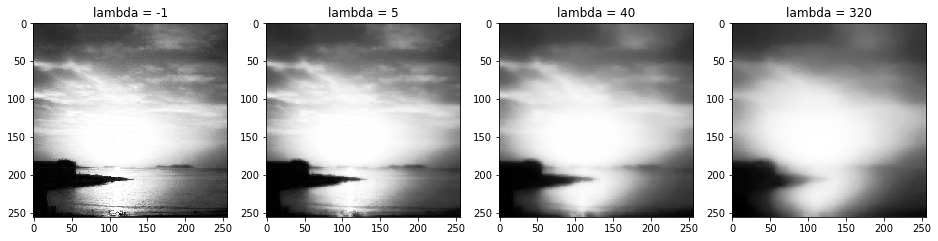

In [10]:
comparePlotList(red, UsRed, lambdas, m, n)

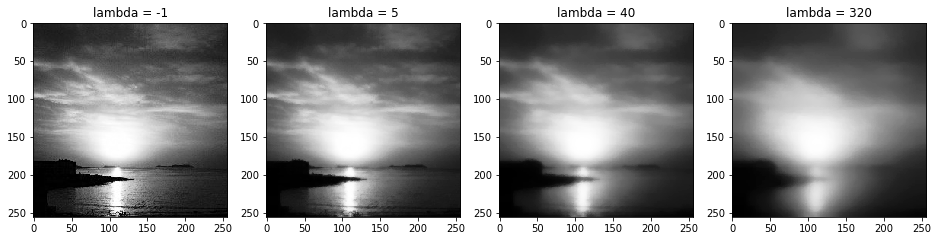

In [11]:
comparePlotList(green, UsGreen, lambdas, m, n)

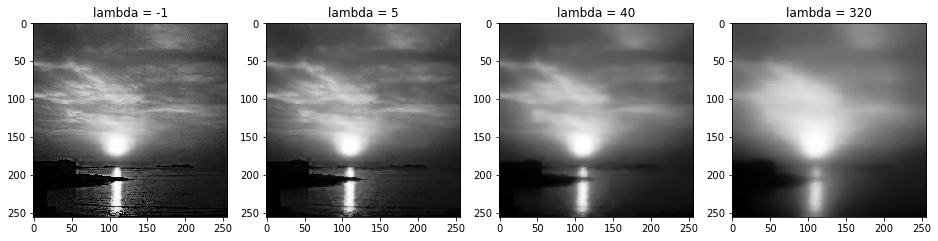

In [12]:
comparePlotList(blue, UsBlue, lambdas, m, n)

In [13]:
Us = []
for i in range(len(lambdas)):
    smoothed_img = np.empty_like(original_image)
    smoothed_img[:, :, 0] = UsRed[i]
    smoothed_img[:, :, 1] = UsGreen[i]
    smoothed_img[:, :, 2] = UsBlue[i]
    Us.append(smoothed_img)

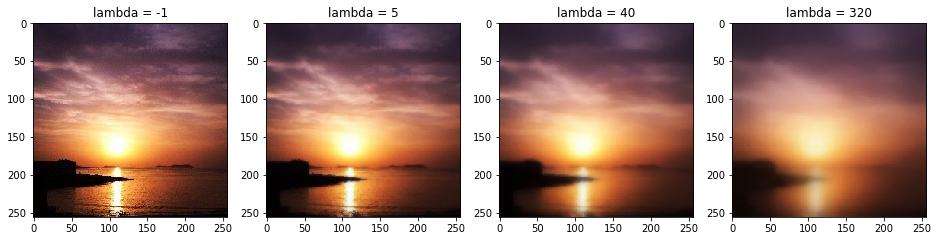

In [14]:
comparePlotList(original_image, Us, lambdas, m, n)

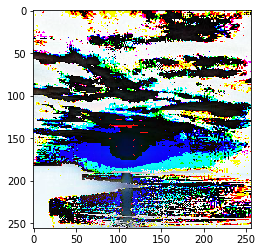

In [15]:
smoothed = Us[2]
details = original_image - smoothed
plot(details)

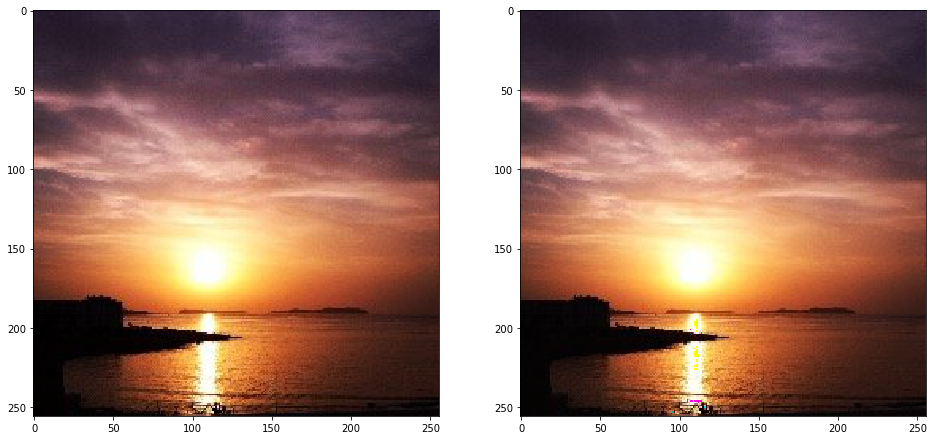

In [20]:
enhanced = original_image + (.01 * details).astype("uint8")
comparePlot(original_image, enhanced)